In [1]:
import numpy as np
from abc import ABC, abstractmethod
from scipy import linalg
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from typing import List, Optional, Union

# ==============================================================================
# 1. Abstract Strategy (The Interface)
# ==============================================================================

class ContextualRisk(ABC):
    """
    Abstract base class for defining the 'Risk' in data selection.
    This allows TAAQ to plug-and-play different objectives (Efficiency vs Robustness).
    """
    @abstractmethod
    def compute_multiplier(
        self,
        M_residual: np.ndarray,
        r_target: Optional[np.ndarray],
        candidates: np.ndarray,
        selected_indices: List[int],
        context: Optional[np.ndarray]
    ) -> np.ndarray:
        """
        Computes the penalty multiplier in [0, 1]. 
        1.0 = Safe (Keep Score), 0.0 = Risky (Suppress).
        """
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}()"

# ==============================================================================
# 2. Concrete Strategies (The Modules)
# ==============================================================================

class GeometricDiversityRisk(ContextualRisk):
    """
    Risk = Redundancy (Geometric Similarity).
    Used for: Efficiency tasks (Coreset, Token Selection).
    """
    def __init__(self, tau: float = 0.2, min_multiplier: float = 0.1):
        self.tau = tau
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context=None):
        n_features = M_residual.shape[1]
        
        # Optimization: Return ones if diversity is disabled or no selection yet
        if not selected_indices or self.tau <= 0:
            return np.ones(n_features)
            
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)

        # Normalize vectors in the current residual space
        X_cand = M_residual[:, active_idx]
        X_sel = M_residual[:, selected_indices]
        
        nc = np.linalg.norm(X_cand, axis=0) + 1e-12
        ns = np.linalg.norm(X_sel, axis=0) + 1e-12
        
        X_cand_n = X_cand / nc
        X_sel_n = X_sel / ns
        
        # Compute Max Cosine Similarity
        # shape: (n_selected, n_candidates) -> max -> (n_candidates,)
        sim = np.abs(X_sel_n.T @ X_cand_n)
        max_sim = np.max(sim, axis=0)
        
        # Compute Penalty: 1 - tau * similarity
        penalties = np.clip(1.0 - self.tau * max_sim, self.min_multiplier, 1.0)
        
        out = np.ones(n_features)
        out[active_idx] = penalties
        return out

    def __repr__(self):
        return f"GeometricDiversityRisk(tau={self.tau})"


class InvariantCausalRisk(ContextualRisk):
    """
    Risk = Instability (Variance across Environments).
    Used for: Robustness tasks (OOD Feature Selection).
    """
    def __init__(self, lambda_var: float = 2.0, lambda_flip: float = 1.0, thr: float = 0.05, min_multiplier: float = 1e-3, var_weighting: str = "count"):
        self.lambda_var = lambda_var
        self.lambda_flip = lambda_flip
        self.thr = thr
        self.min_multiplier = min_multiplier
        self.var_weighting = var_weighting

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        if context is None:
            raise ValueError("InvariantCausalRisk requires 'context' (environment IDs).")
        if r_target is None:
            raise ValueError("InvariantCausalRisk requires 'y' (target vector).")
            
        n_features = M_residual.shape[1]
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)
            
        eps = 1e-9
        Xa = M_residual[:, active_idx]
        
        # Handle environment statistics
        envs, counts = np.unique(context, return_counts=True)
        if envs.size < 2:
            # Cannot compute variance with < 2 environments
            return np.ones(n_features)
            
        corr_list, w_list = [], []
        for e, c in zip(envs, counts):
            mask = context == e
            if np.sum(mask) < 2: continue
                
            X_e = Xa[mask]
            y_e = r_target[mask]
            
            # Center and scale for correlation (slope) calculation
            y_e = y_e - y_e.mean()
            ny = np.linalg.norm(y_e) + eps
            
            X_e = X_e - X_e.mean(axis=0, keepdims=True)
            nx = np.linalg.norm(X_e, axis=0) + eps
            
            corr_e = (X_e.T @ y_e) / (nx * ny)
            corr_list.append(corr_e)
            w_list.append(float(c))
            
        if not corr_list:
            return np.ones(n_features)

        C = np.vstack(corr_list)
        
        # 1. Variance Risk (Weighted or Standard)
        if self.var_weighting == "count":
            w = np.asarray(w_list, dtype=float)
            w = w / (w.sum() + eps)
            mean = (w[:, None] * C).sum(axis=0)
            var_risk = (w[:, None] * (C - mean) ** 2).sum(axis=0)
        else:
            var_risk = np.var(C, axis=0)
        
        # 2. Sign-Flip Risk
        sig = np.abs(C) > self.thr
        has_pos = np.any((C > 0) & sig, axis=0)
        has_neg = np.any((C < 0) & sig, axis=0)
        flip_risk = (has_pos & has_neg).astype(float)
        
        # Total Penalty
        total_risk = self.lambda_var * var_risk + self.lambda_flip * flip_risk
        penalty = 1.0 / (1.0 + total_risk)
        
        penalty = np.clip(penalty, self.min_multiplier, 1.0)
        out = np.ones(n_features)
        out[active_idx] = penalty
        return out

    def __repr__(self):
        return f"InvariantCausalRisk(var={self.lambda_var}, flip={self.lambda_flip})"


class CompositeRisk(ContextualRisk):
    """
    Combines multiple risks (e.g., Efficiency + Robustness).
    """
    def __init__(self, risks: List[ContextualRisk], combine: str = "product", min_multiplier: float = 1e-3):
        self.risks = risks
        self.combine = combine
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        outs = [r.compute_multiplier(M_residual, r_target, candidates, selected_indices, context) for r in self.risks]
        
        if not outs:
            return np.ones(M_residual.shape[1])
            
        if self.combine == "product":
            m = np.prod(outs, axis=0)
        elif self.combine == "min":
            m = np.min(outs, axis=0)
        else: # average
            m = np.mean(outs, axis=0)
            
        return np.clip(m, self.min_multiplier, 1.0)

    def __repr__(self):
        return f"CompositeRisk(risks={self.risks})"


# ==============================================================================
# 3. The Unified Engine (TAAQ)
# ==============================================================================

class TAAQ(BaseEstimator, TransformerMixin):
    """
    The Unified Spectral Selection Engine.
    Delegates risk calculation to the injected 'risk_strategy'.
    """
    def __init__(self, k: int, risk_strategy: ContextualRisk, k1_ratio: float = 0.1, epsilon: float = 1e-9, verbose: bool = False):
        self.k = k
        self.risk_strategy = risk_strategy
        self.k1_ratio = k1_ratio
        self.epsilon = epsilon
        self.verbose = verbose
        self.selected_indices_ = None
        self.n_features_in_ = None

    def fit(self, X, y=None, context=None):
        """
        Fit the TAAQ model.
        """
        X = check_array(X)
        n_samples, n_features = X.shape
        
        if not (1 <= self.k <= n_features):
            raise ValueError(f"k must be in [1, n_features={n_features}].")
            
        self.n_features_in_ = n_features
        
        # Standardization (Required for Spectral Methods)
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0) + self.epsilon
        M = (X - X_mean) / X_std
        
        # Target Preprocessing
        r = None
        if y is not None:
            y = np.asarray(y, dtype=float)
            yc = y - y.mean()
            ny = np.linalg.norm(yc)
            if ny > self.epsilon:
                r = (yc / ny * np.sqrt(n_samples))
            else:
                r = yc
                
        # --- Phase 1: Spectral Gating (QRCP) ---
        k1 = int(self.k * self.k1_ratio)
        k1 = max(0, min(k1, n_features, self.k))
        S: List[int] = []
        
        if k1 > 0:
            Q, _, P = linalg.qr(M, mode="economic", pivoting=True)
            # Safety check for rank deficiency
            qcols = Q.shape[1]
            if qcols > 0:
                k1 = min(k1, qcols)
                S = list(P[:k1])
                Qg = Q[:, :k1]
                # Project out gated subspace
                M = M - Qg @ (Qg.T @ M)
                if r is not None:
                    r = r - Qg @ (Qg.T @ r)
            else:
                k1 = 0
        
        # --- Phase 2: Generalized Greedy Selection ---
        candidates = np.ones(n_features, dtype=bool)
        if S:
            candidates[S] = False
            
        while len(S) < self.k:
            # A. Compute Signal (Energy or Alignment)
            norms_sq = np.sum(M**2, axis=0)
            valid_mask = (norms_sq > self.epsilon) & candidates
            
            if not np.any(valid_mask):
                if self.verbose: print("Converged early: No more energy.")
                break
            
            if r is not None:
                # Supervised Alignment
                dots = M.T @ r
                signal = (dots**2) / (norms_sq + self.epsilon)
            else:
                # Unsupervised Energy
                signal = norms_sq
            
            # B. Compute Risk Multiplier (Strategy Call)
            mult = self.risk_strategy.compute_multiplier(M, r, valid_mask, S, context)
            
            # C. Selection
            scores = np.zeros(n_features)
            scores[valid_mask] = signal[valid_mask] * mult[valid_mask]
            
            best_idx = int(np.argmax(scores))
            S.append(best_idx)
            candidates[best_idx] = False
            
            # D. Residual Update (OMP Step)
            x = M[:, best_idx]
            nx = np.linalg.norm(x)
            
            if nx > self.epsilon:
                u = x / nx
                # M <- M - u u^T M
                proj = u @ M
                M = M - np.outer(u, proj)
                
                if r is not None:
                    r = r - (u @ r) * u
                    
        self.selected_indices_ = np.array(S, dtype=int)
        return self

    def transform(self, X):
        X = check_array(X)
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        return X[:, self.selected_indices_]

    def get_support(self, indices: bool = False):
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        if indices:
            return self.selected_indices_.copy()
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

    def fit_transform(self, X, y=None, context=None):
        self.fit(X, y=y, context=context)
        return self.transform(X)


# ==============================================================================
# 4. Factory Functions (User API)
# ==============================================================================

def TAAQ_Efficiency(k, k1_ratio=0.25, tau=0.2, min_multiplier=0.1):
    """Factory for Efficiency Mode (Geometric Diversity only)."""
    strategy = GeometricDiversityRisk(tau=tau, min_multiplier=min_multiplier)
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_RobustnessPure(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Robustness Mode.
    """
    strategy = InvariantCausalRisk(
        lambda_var=lambda_var, 
        lambda_flip=lambda_flip, 
        thr=thr, 
        min_multiplier=min_multiplier, 
        var_weighting=var_weighting
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_Hybrid(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, tau=0.2, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Hybrid Mode..
    """
    strategy = CompositeRisk(
        [
            InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting),
            GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)),
        ],
        combine="product",
        min_multiplier=min_multiplier,
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)
    
def TAAQ_Universal(k, k1_ratio=0.1, lambda_var=2.0, lambda_flip=1.0, thr=0.05, tau=0.0, min_multiplier=1e-3, var_weighting="count"):
    """Factory for auto-configuring based on parameters."""
    risks = [InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting)]
    if tau > 0:
        risks.append(GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)))
        strategy = CompositeRisk(risks, combine="product", min_multiplier=min_multiplier)
    else:
        strategy = risks[0]
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

Running Token Selection (Minority Signal)...


100%|██████████| 5/5 [02:01<00:00, 24.38s/it]


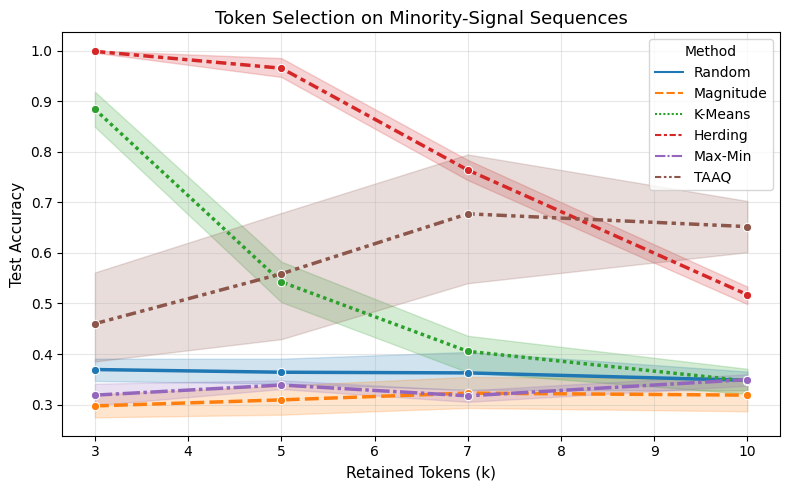

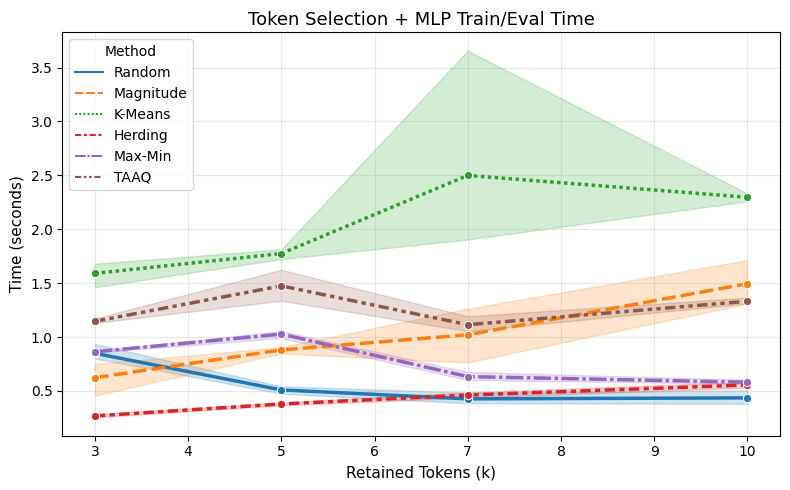


[Token Accuracy Summary]
k             3      5      7      10
Method                               
Herding    0.999  0.965  0.764  0.517
K-Means    0.884  0.543  0.405  0.347
Magnitude  0.297  0.309  0.323  0.319
Max-Min    0.319  0.339  0.317  0.349
Random     0.369  0.364  0.363  0.348
TAAQ       0.460  0.559  0.677  0.652

[Token Time Summary]
k             3      5      7      10
Method                               
Herding    0.269  0.380  0.462  0.556
K-Means    1.591  1.775  2.500  2.297
Magnitude  0.623  0.881  1.021  1.495
Max-Min    0.864  1.028  0.633  0.582
Random     0.850  0.510  0.427  0.436
TAAQ       1.146  1.475  1.115  1.332


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import time
import warnings

warnings.filterwarnings("ignore")


def generate_minority_signal(n_samples=500, seq_len=100, dim=64, n_classes=3, seed=42):
    rng = np.random.default_rng(seed)
    X = np.zeros((n_samples, seq_len, dim))
    y = np.zeros(n_samples, dtype=int)

    n_noise_types = 10
    noise_patterns = rng.normal(0, 2.0, (n_noise_types, dim))
    class_patterns = rng.normal(0, 1.0, (n_classes, dim))

    for i in range(n_samples):
        label = int(rng.integers(0, n_classes))
        y[i] = label

        noise_indices = rng.integers(0, n_noise_types, seq_len)
        sequence = noise_patterns[noise_indices] + rng.normal(0, 0.2, (seq_len, dim))

        n_signal = 3
        pos = rng.choice(seq_len, n_signal, replace=False)
        sequence[pos] = class_patterns[label] + rng.normal(0, 0.1, (n_signal, dim))

        X[i] = sequence

    return X, y


def select_magnitude(X_seq, k):
    norms = np.linalg.norm(X_seq, axis=1)
    return np.argsort(-norms)[:k]


def select_kmeans(X_seq, k, seed):
    n = len(X_seq)
    if k >= n:
        return np.arange(n, dtype=int)

    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=seed)
    kmeans.fit(X_seq)
    centers = kmeans.cluster_centers_

    selected = []
    for center in centers:
        dists = np.linalg.norm(X_seq - center, axis=1)
        selected.append(int(np.argmin(dists)))

    selected_unique = list(dict.fromkeys(selected))
    if len(selected_unique) < k:
        remaining = np.setdiff1d(
            np.arange(n, dtype=int),
            np.array(selected_unique, dtype=int),
            assume_unique=False,
        )
        if remaining.size > 0:
            rng = np.random.default_rng(seed + 123)
            extra = rng.choice(
                remaining,
                size=min(k - len(selected_unique), remaining.size),
                replace=False,
            )
            selected_unique.extend(extra.tolist())

    return np.array(selected_unique[:k], dtype=int)


def herding_selection(X_seq, k):
    if k <= 0:
        return np.array([], dtype=int)
    mu = np.mean(X_seq, axis=0)
    selected_indices = []
    current_sum = np.zeros_like(mu)
    mask = np.ones(len(X_seq), dtype=bool)
    for t in range(1, k + 1):
        target = t * mu - current_sum
        candidates_idx = np.where(mask)[0]
        if candidates_idx.size == 0:
            break
        dists = np.linalg.norm(X_seq[candidates_idx] - target, axis=1)
        best_global = int(candidates_idx[np.argmin(dists)])
        selected_indices.append(best_global)
        current_sum += X_seq[best_global]
        mask[best_global] = False
    return np.array(selected_indices[:k], dtype=int)


def max_min_diversity(X_seq, k, seed):
    n = len(X_seq)
    if k <= 0:
        return np.array([], dtype=int)
    rng = np.random.default_rng(seed)
    first_idx = int(rng.integers(0, n))
    selected_indices = [first_idx]
    min_dists = np.linalg.norm(X_seq - X_seq[first_idx], axis=1)
    for _ in range(1, k):
        new_idx = int(np.argmax(min_dists))
        selected_indices.append(new_idx)
        new_dists_vec = np.linalg.norm(X_seq - X_seq[new_idx], axis=1)
        min_dists = np.minimum(min_dists, new_dists_vec)
    return np.array(selected_indices[:k], dtype=int)


def run_token_experiment():
    SEEDS = [0, 1, 2, 3, 4]
    BUDGETS = [3, 5, 7, 10]

    results = []

    print("Running Token Selection (Minority Signal)...")

    for seed in tqdm(SEEDS):
        X, y = generate_minority_signal(seed=seed)
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=0.3, random_state=seed, stratify=y
        )

        for k in BUDGETS:
            rng = np.random.default_rng(seed + 1000 * k)

            methods = {
                "Random": lambda x: rng.choice(len(x), k, replace=False),
                "Magnitude": lambda x: select_magnitude(x, k),
                "K-Means": lambda x: select_kmeans(x, k, seed),
                "Herding": lambda x: herding_selection(x, k),
                "Max-Min": lambda x: max_min_diversity(x, k, seed),
                "TAAQ": None,
            }

            taaq = TAAQ_Efficiency(k=k, k1_ratio=0.0, tau=0.3)

            for name, func in methods.items():
                t0 = time.time()

                def transform_dataset(dataset):
                    flattened = []
                    for seq in dataset:
                        if name == "TAAQ":
                            taaq.fit(seq.T, y=None)
                            idx = taaq.selected_indices_
                        else:
                            idx = func(seq)
                        idx = np.sort(idx)
                        tokens = seq[idx]
                        if len(tokens) < k:
                            pad = np.zeros((k - len(tokens), seq.shape[1]))
                            tokens = np.vstack([tokens, pad])
                        elif len(tokens) > k:
                            tokens = tokens[:k]
                        flattened.append(tokens.flatten())
                    return np.array(flattened)

                X_tr_sel = transform_dataset(X_tr)
                X_te_sel = transform_dataset(X_te)

                t_select = time.time() - t0

                t1 = time.time()
                clf = MLPClassifier(
                    hidden_layer_sizes=(32,),
                    max_iter=500,
                    random_state=seed,
                )
                clf.fit(X_tr_sel, y_tr)
                acc = accuracy_score(y_te, clf.predict(X_te_sel))
                t_train_eval = time.time() - t1

                total_time = t_select + t_train_eval

                results.append(
                    {
                        "Method": name,
                        "k": k,
                        "Accuracy": acc,
                        "Time": total_time,
                    }
                )

    return pd.DataFrame(results)


df_token = run_token_experiment()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_token,
    x="k",
    y="Accuracy",
    hue="Method",
    marker="o",
    style="Method",
    linewidth=2.5,
)
plt.title("Token Selection on Minority-Signal Sequences", fontsize=13)
plt.ylabel("Test Accuracy", fontsize=11)
plt.xlabel("Retained Tokens (k)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_token,
    x="k",
    y="Time",
    hue="Method",
    marker="o",
    style="Method",
    linewidth=2.5,
)
plt.title("Token Selection + MLP Train/Eval Time", fontsize=13)
plt.ylabel("Time (seconds)", fontsize=11)
plt.xlabel("Retained Tokens (k)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n[Token Accuracy Summary]")
print(
    df_token.groupby(["Method", "k"])["Accuracy"]
    .mean()
    .unstack()
    .round(3)
)

print("\n[Token Time Summary]")
print(
    df_token.groupby(["Method", "k"])["Time"]
    .mean()
    .unstack()
    .round(3)
)
